In [106]:
#| default_exp hedgerprep

# Documentation
## Datasets
* xdf: raw data 

In [107]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
from fastai.tabular.all import *
import nbdev
import gzip
import time


In [108]:
#| export
def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

# Parameters

In [109]:
#| export

stop_loss_tick = 2
tick_size = 0.01

if is_notebook():
    data_dir = Path("../market")
    save_dir = Path("../market/save")
    market_open = "09:30"
    rows_to_load = 500_000     # should be -1 for training, or positive smaller for faster testing
    load_date = "20250327"

    day_sample_count = 5000
    stock_to_load = 'JPM'
    print("Running in Jupyter Notebook")
else:
    data_dir = Path("../market")
    save_dir = Path("../market/save")
    market_open = "09:30"
    rows_to_load = -1     # should be -1 for training, or positive smaller for faster testing

    day_sample_count = 5000
    stock_to_load = None


Running in Jupyter Notebook


# Load data

In [110]:
#| export

def process_bento_file(file_path):
    import databento as db
    store = db.DBNStore.from_file(file_path)
    _df = store.to_df(schema="mbp-10")
    df = _df
    if stock_to_load is not None:
        df = _df[_df.symbol == stock_to_load]

    # the datastore loaded is indexed by ts_event, for everything we need it to be integer
    df.reset_index(drop=True, inplace=True)
    return df

def process_csv(file_path):
    return pd.read_csv(file_path, nrows=rows_to_load if rows_to_load > 0 else None, usecols=columns_to_load, dtype=dtype_mapping, parse_dates=["ts_event"])


def load_data(date):

    columns_to_load = [
        "ts_event", 
        "instrument_id", "action", "side", 
        #"depth", 
        "price", "size", 
        "bid_px_00", "ask_px_00", "bid_sz_00", "ask_sz_00", 
        "bid_px_01", "ask_px_01", "bid_sz_01", "ask_sz_01", 
        "bid_px_02", "ask_px_02", "bid_sz_02", "ask_sz_02", 
        "bid_px_03", "ask_px_03", "bid_sz_03", "ask_sz_03", 
        "bid_px_04", "ask_px_04", "bid_sz_04", "ask_sz_04", 
        "bid_px_05", "ask_px_05", "bid_sz_05", "ask_sz_05", 
        "bid_px_06", "ask_px_06", "bid_sz_06", "ask_sz_06", 
        "bid_px_07", "ask_px_07", "bid_sz_07", "ask_sz_07", 
        "bid_px_08", "ask_px_08", "bid_sz_08", "ask_sz_08", 
        "bid_px_09", "ask_px_09", "bid_sz_09", "ask_sz_09"
    ]

    dtype_mapping = {col: "float32" for col in columns_to_load if "_px_" in col}
    dtype_mapping.update({col: "int32" for col in columns_to_load if "_sz_" in col})
    dtype_mapping.update({
        "instrument_id": "int32",
        "action": "category",
        "side": "category",
        "price": "float32",
        "size": "int32",
    })

    file_extensions = {
        ".mbp-10.csv" : process_csv,
        ".mbp-10.csv.gz": process_csv,
        ".mbp-10.dbn.zst": process_bento_file,
        ".mbp-10.zst": process_bento_file
    }

    for ext in file_extensions.keys():
        if (file_path := data_dir / f"xnas-itch-{date}{ext}").exists():
            df = file_extensions[ext](file_path)
            break
    else:
        raise FileNotFoundError(f"No valid file found for date {date} in {data_dir}")


    print(f"Loaded {len(df)} rows from {file_path}, memory usage: {df.memory_usage(deep=True).sum() / 1e6:.2f} MB")
    return df

In [111]:
xdf = load_data(load_date)


Loaded 211476 rows from ../market/xnas-itch-20250327.mbp-10.dbn.zst, memory usage: 112.72 MB


#### Adjust timestamps + drop outside market hours

In [146]:
#| export
def adjust_for_time(df):
    if not pd.api.types.is_datetime64_any_dtype(df["ts_event"]):
        df["ts_event"] = pd.to_datetime(df.ts_event, unit="ns")
    df["ts_event"] = df["ts_event"].dt.tz_convert('US/Eastern')
    df = df[df["ts_event"].dt.time >= pd.to_datetime("09:30").time()]
    df = df[df["ts_event"].dt.time <= pd.to_datetime("16:00").time()]
    market_open = pd.to_datetime("09:30").time()
    df['ns_since_open'] = (df['ts_event'] - df['ts_event'].dt.normalize() - pd.to_timedelta(market_open.hour, unit='h') - pd.to_timedelta(market_open.minute, unit='m')).dt.total_seconds() * 1e9 + df['ts_event'].dt.nanosecond
    import pytz
    pytz

    df['day_of_week'] = df['ts_event'].dt.dayofweek
    df['day_in_year'] = df['ts_event'].dt.dayofyear
    
    df['is_third_friday'] = (
        (df['ts_event'].dt.weekday == 4) &  # Friday
        (df['ts_event'].dt.day >= 15) & 
        (df['ts_event'].dt.day <= 21)
    )

    df['is_first_monday_after_third_friday'] = (
        (df['ts_event'].dt.weekday == 0) &  # Monday
        (df['ts_event'].dt.day > 15) & 
        (df['ts_event'].dt.day <= 28) & 
        (df['ts_event'] - pd.to_timedelta(df['ts_event'].dt.weekday, unit='D')).dt.day >= 15
    )
    
    df['is_day_before_third_friday'] = (
        (df['ts_event'].dt.weekday == 3) &  # Thursday
        (df['ts_event'].dt.day >= 14) & 
        (df['ts_event'].dt.day <= 20)
    )
    #df = add_datepart(df, 'ts_event', drop=False)

    return df

In [148]:
xdf = adjust_for_time(xdf)
' '.join(o for o in xdf.columns if o.startswith('ts_event'))


'ts_event'

#### Cleanup (drop rows with NA)

In [115]:
#| export
def drop_na(df):
    orig_len = df.shape[0]
    df.dropna(inplace=True)
    cur_len = df.shape[0]
    drop_cnt = orig_len-cur_len
    if  drop_cnt > 1000:
        raise Exception(f"{drop_cnt} rows dropped, seems a lot")
    else:
        print(f"{drop_cnt} dropped out of {orig_len}")

In [116]:
drop_na(xdf)

0 dropped out of 194509


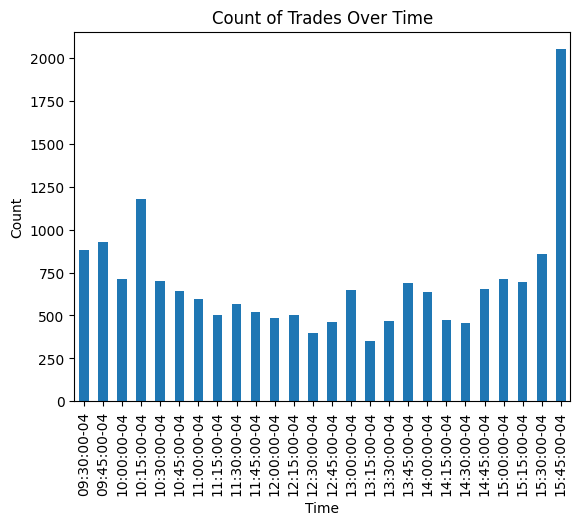

In [117]:
# Filter the dataframe for action "T"
df_trades = xdf[xdf['action'] == "T"]

# Group by buckets of 15 minutes
df_trades.set_index('ts_event').resample('15min').size().plot(kind='bar', title='Count of Trades Over Time')
plot.xlabel('Time')
#plot.xticks(rotation=45)
labels = [item.get_text().split(' ')[1].split('+')[0][:-3] for item in plot.gca().get_xticklabels()]
plot.gca().set_xticklabels(labels)
plot.ylabel('Count')
plot.show()

In [118]:
trades = xdf[(xdf.action == "T") & (xdf.side != "N")]
cols = ["action", "side", "price", "size", "bid_sz_00", "bid_px_00", "ask_px_00", "ask_sz_00",
         "bid_sz_01", "bid_px_01", "ask_px_01", "ask_sz_01"]
trades.side.value_counts()


side
B    6750
A    5177
Name: count, dtype: int64

In [119]:
def display_around(idx, nbrows=6):
    iloc_index = xdf.index.get_loc(idx)
    return xdf.iloc[iloc_index-1:iloc_index+nbrows-1][cols]
idx = 0

In [120]:
x = display_around(trades.index[idx])
print(idx, trades.index[idx])
idx = idx + 1
x

0 16592


,action,side,price,size,bid_sz_00,bid_px_00,ask_px_00,ask_sz_00,bid_sz_01,bid_px_01,ask_px_01,ask_sz_01
16591,C,B,249.05,25,50,248.95,249.84,66,41,248.91,250.34,25
16592,T,B,249.84,41,50,248.95,249.84,66,41,248.91,250.34,25
16593,T,B,249.84,25,50,248.95,249.84,25,41,248.91,250.34,25
16594,C,A,249.84,25,50,248.95,250.34,25,41,248.91,250.84,25
16595,A,B,249.13,100,82,249.48,250.34,25,100,249.13,250.84,25
16596,A,B,249.39,45,82,249.48,250.34,25,54,249.39,250.84,25


#### Add spread

In [121]:
#| export
def add_spread(df):
    df['spread'] = (df['ask_px_00'] - df['bid_px_00'])/((df['bid_px_00']+df['ask_px_00'])/2)

<Axes: title={'center': 'Spread Over Time'}>

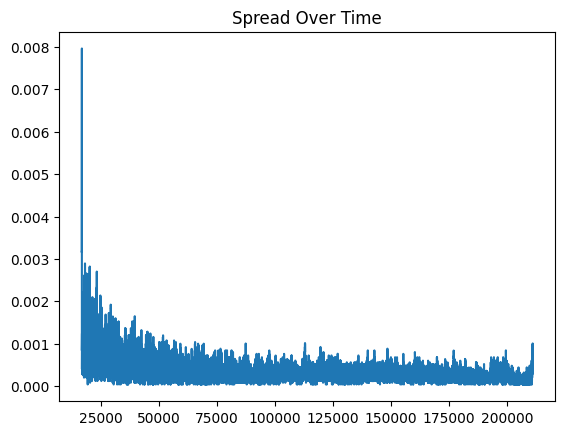

In [122]:
add_spread(xdf)
xdf['spread'].plot(title='Spread Over Time')

### calculate imbalance

In [123]:
#| export
def calc_bid_weight(row):
    return  np.array([row['mid']/(row['mid']-row[f'bid_px_0{i}'])*row[f'bid_sz_0{i}'] for i in range(0,10)]).sum(axis=0)
def calc_ask_weight(row): 
    return np.array([row['mid']/(row[f'ask_px_0{i}']-row['mid'])*row[f'ask_sz_0{i}'] for i in range(0,10)]).sum(axis=0)    

def add_imbalance_columns(df):
    # want to calculate the amount but also how spread out it is
    df['mid'] = (df['bid_px_00']+df['ask_px_00'])/2
    df['bid_weight'] = calc_bid_weight(df)
    df['ask_weight'] = calc_ask_weight(df)
    df['bid_weight_log'] = np.log(df['bid_weight'])
    df['ask_weight_log'] = np.log(df['ask_weight'])


In [124]:
add_imbalance_columns(xdf)
xdf[['bid_weight', 'ask_weight', 'bid_weight_log', 'ask_weight_log']].describe()

,bid_weight,ask_weight,bid_weight_log,ask_weight_log
count,1.945090e+05,1.945090e+05,194509.000000,194509.000000
mean,1.555259e+06,2.155683e+06,13.991231,14.371641
std,1.375557e+06,1.441274e+06,0.739129,0.693966
min,3.725135e+04,2.720614e+04,10.525444,10.211198
25%,7.671033e+05,1.205370e+06,13.550377,14.002298
50%,1.226904e+06,1.885334e+06,14.020004,14.449615
75%,1.912681e+06,2.751849e+06,14.464017,14.827784
max,5.624169e+07,2.827786e+07,17.845169,17.157590


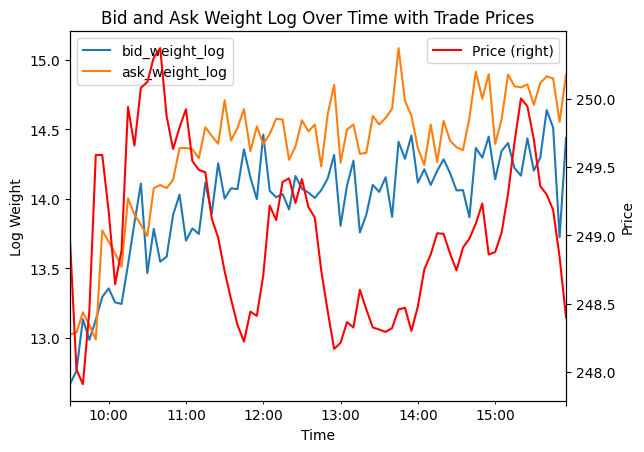

In [125]:

ax = xdf.set_index('ts_event')[['bid_weight_log', 'ask_weight_log']].resample('5min').mean().plot()
xdf[xdf['action'] == 'T'].set_index('ts_event')['price'].resample('5min').mean().plot(ax=ax, secondary_y=True, color='r', label='Price')
ax.set_xlabel('Time')
ax.set_ylabel('Log Weight')
ax.right_ax.set_ylabel('Price')
ax.set_title('Bid and Ask Weight Log Over Time with Trade Prices')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')
plot.show()

### Calculating trades on the bid and ask side


In [126]:
#| export
def add_rolling_trades_cols(_df):
    # add a column with a the traded size by row, with 0 for non trade rows
    # this makes the next calculation easier
    df = _df.copy()
    df["traded_bid_size"] = df["size"] * ((df["action"] == "T") & (df["side"] == "B"))
    df["traded_ask_size"] = df["size"] * ((df["action"] == "T") & (df["side"] == "A"))
    df["is_trade_bid"] = ((df["action"] == "T") & (df["side"] == "B")) * 1
    df["is_trade_ask"] = ((df["action"] == "T") & (df["side"] == "A")) * 1

    def _add_rolling_trades_cols(period):
        # temporary dataset so we can reindex
        x = df[['ts_event', 'traded_bid_size', 'traded_ask_size', 'is_trade_bid', 'is_trade_ask']].copy()
        x['original_index'] = df.index
        x.set_index("ts_event", inplace=True)

        # calculate
        x[f'rolling_{period}_bid_size'] = x["traded_bid_size"].rolling(period).sum()
        x[f'rolling_{period}_ask_size'] = x["traded_ask_size"].rolling(period).sum()
        x[f'rolling_{period}_bid_cnt'] = x["is_trade_bid"].rolling(period).sum()
        x[f'rolling_{period}_ask_cnt'] = x["is_trade_ask"].rolling(period).sum()

        # merge back to original dataframe
        x.set_index("original_index", inplace=True)
        _df[f'rolling_{period}_bid_size'] = x[f'rolling_{period}_bid_size']
        _df[f'rolling_{period}_ask_size'] = x[f'rolling_{period}_ask_size']
        _df[f'rolling_{period}_bid_cnt'] = x[f'rolling_{period}_bid_cnt']
        _df[f'rolling_{period}_ask_cnt'] = x[f'rolling_{period}_ask_cnt']


    _add_rolling_trades_cols('30s')
    _add_rolling_trades_cols('5min')

    # and no cleanup needed as the temp columns were added to a copy
    #_ = _df.drop(columns=['traded_bid_size', 'traded_ask_size', 'is_trade_bid', 'is_trade_ask'])



In [127]:
add_rolling_trades_cols(xdf)

In [128]:
xdf

,ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,...,bid_weight_log,ask_weight_log,rolling_30s_bid_size,rolling_30s_ask_size,rolling_30s_bid_cnt,rolling_30s_ask_cnt,rolling_5min_bid_size,rolling_5min_ask_size,rolling_5min_bid_cnt,rolling_5min_ask_cnt
16581,2025-03-27 09:30:00.034525890-04:00,10,2,9155,A,B,0,249.05,80,130,...,12.090758,11.276264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16582,2025-03-27 09:30:00.554411025-04:00,10,2,9155,A,B,0,249.05,25,128,...,12.175638,11.276264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16583,2025-03-27 09:30:00.555367251-04:00,10,2,9155,A,A,0,249.84,25,128,...,12.175638,11.458612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16584,2025-03-27 09:30:00.556371280-04:00,10,2,9155,A,A,1,250.34,25,128,...,12.107112,11.528908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16585,2025-03-27 09:30:00.557779813-04:00,10,2,9155,A,B,4,248.05,25,128,...,11.977516,11.528908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211085,2025-03-27 15:59:59.403900065-04:00,10,2,9155,A,A,0,248.23,50,128,...,13.471111,13.610096,1633.0,2355.0,52.0,89.0,8036.0,8523.0,307.0,340.0
211086,2025-03-27 15:59:59.411353240-04:00,10,2,9155,A,B,0,247.99,96,130,...,13.718045,13.610096,1633.0,2355.0,52.0,89.0,8036.0,8523.0,307.0,340.0
211087,2025-03-27 15:59:59.439425303-04:00,10,2,9155,T,N,0,248.14,23,130,...,13.718045,13.610096,1633.0,2355.0,52.0,89.0,8036.0,8523.0,307.0,340.0
211088,2025-03-27 15:59:59.442755671-04:00,10,2,9155,T,N,0,248.14,8,130,...,13.718045,13.610096,1633.0,2355.0,52.0,89.0,8036.0,8523.0,307.0,340.0


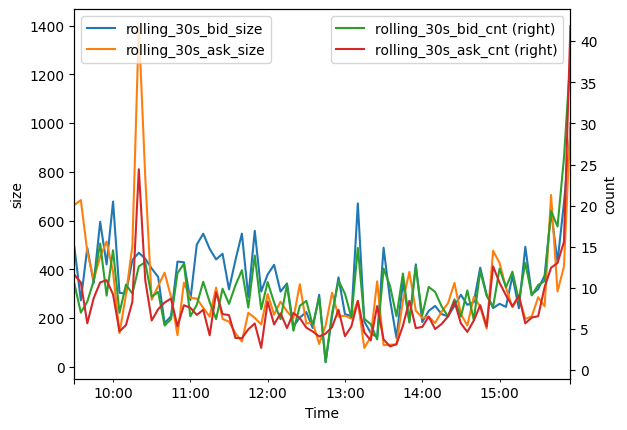

In [129]:
ax = xdf.set_index('ts_event')[['rolling_30s_bid_size', 'rolling_30s_ask_size']].resample('5min').mean().plot()
xdf.set_index('ts_event')[['rolling_30s_bid_cnt', 'rolling_30s_ask_cnt']].resample('5min').mean().plot(ax=ax, secondary_y=True)
ax.set_xlabel('Time')
ax.set_ylabel('size')
ax.right_ax.set_ylabel('count')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')
plot.show()

### Identify the stop price and location (index) for each row

In [130]:
#| export
from joblib import Parallel, delayed
def calc_stop_loss_indices(df):
    # reduce dataset
    rdf = df[df['action'] == 'A'].sample(n=day_sample_count)
    
    stop_loss_currency = stop_loss_tick * tick_size - (tick_size / 10.0)  # substract 1/10 tick otherwise I get issues with floating point approximations
    
    rdf['hedge_buy_stop_idx'] = rdf.apply(lambda row: df.index[(df.index > row.name) & (df['ask_px_00'] >= row['ask_px_00']+ stop_loss_currency )].min(), axis=1)
    rdf['hedge_sell_stop_idx'] = rdf.apply(lambda row: df.index[(df.index > row.name) & (df['bid_px_00'] <= row['bid_px_00']- stop_loss_currency)].min(), axis=1)

    # add columns with the stop loss prices, will come handy when we introduce latency
    rdf['hedge_buy_stop_prc'] = rdf.loc[rdf['hedge_buy_stop_idx'].notnull()]['ask_px_00']
    rdf['hedge_sell_stop_prc'] = rdf.loc[rdf['hedge_sell_stop_idx'].notnull()]['bid_px_00']

    # fix NaN values
    rdf['hedge_buy_stop_idx'] = rdf['hedge_buy_stop_idx'].where(~rdf['hedge_buy_stop_idx'].isna(), rdf.index)
    rdf['hedge_sell_stop_idx'] = rdf['hedge_sell_stop_idx'].where(~rdf['hedge_sell_stop_idx'].isna(), rdf.index)

    rdf['hedge_buy_stop_prc'] = rdf['hedge_buy_stop_prc'].where(~rdf['hedge_buy_stop_prc'].isna(), rdf['ask_px_00'])
    rdf['hedge_sell_stop_prc'] = rdf['hedge_sell_stop_prc'].where(~rdf['hedge_sell_stop_prc'].isna(), rdf['bid_px_00'])

    # convert idexes to int
    rdf['hedge_buy_stop_idx'] = rdf['hedge_buy_stop_idx'].astype('int', errors='raise')
    rdf['hedge_sell_stop_idx'] = rdf['hedge_sell_stop_idx'].astype('int', errors='raise')
    return rdf


In [131]:
rdf = calc_stop_loss_indices(xdf)
rdf.shape

(5000, 97)

### Test

In [132]:
idx = 0

In [133]:
idx = idx + 1
print(f"index: {rdf.iloc[idx].name} stop: {rdf.iloc[idx]['hedge_buy_stop_idx']}")
display_around(rdf.iloc[idx].name, int(rdf.iloc[idx]['hedge_buy_stop_idx']) - rdf.iloc[idx].name + 8)


index: 141380 stop: 141479


,action,side,price,size,bid_sz_00,bid_px_00,ask_px_00,ask_sz_00,bid_sz_01,bid_px_01,ask_px_01,ask_sz_01
141379,A,A,248.98,25,24,248.91,248.98,44,1,248.87,249.00,100
141380,A,A,249.06,3,24,248.91,248.98,44,1,248.87,249.00,100
141381,A,B,248.89,100,24,248.91,248.98,44,100,248.89,249.00,100
141382,A,A,248.97,1,24,248.91,248.97,1,100,248.89,248.98,44
141383,C,A,248.98,25,24,248.91,248.97,1,100,248.89,248.98,19
...,...,...,...,...,...,...,...,...,...,...,...,...
141481,A,B,248.89,1,195,248.89,249.00,52,1,248.86,249.05,104
141482,C,A,249.06,5,195,248.89,249.00,52,1,248.86,249.05,104
141483,A,B,248.84,4,195,248.89,249.00,52,1,248.86,249.05,104
141484,C,A,249.00,25,195,248.89,249.00,27,1,248.86,249.05,104


### Calculate optimal hedge price

In [134]:
#| export
def calculate_ideal_hedge(df, rdf):
    def optimal_buy_price(row):
        idx = df.index.get_loc(row.name)
        return df.iloc[idx:idx+1+row['hedge_buy_stop_idx']]['ask_px_00'].min()

    def optimal_sell_price(row):
        idx = df.index.get_loc(row.name)
        return df.iloc[idx:idx+1+row['hedge_sell_stop_idx']]['bid_px_00'].max()

    # calculate ideal position between current point and stop loss point 
    rdf['ideal_buy_price'] = rdf.apply(optimal_buy_price, axis=1)
    rdf['ideal_sell_price'] = rdf.apply(optimal_sell_price, axis=1)

    rdf['ideal_buy_price_spread'] = (rdf['ideal_buy_price'] - rdf['bid_px_00']) / (rdf['ask_px_00'] - rdf['bid_px_00'])
    rdf['ideal_sell_price_spread'] = -(rdf['ideal_sell_price'] - rdf['ask_px_00']) / (rdf['ask_px_00'] - rdf['bid_px_00'])

In [135]:
calculate_ideal_hedge(xdf, rdf)
assert not rdf.isnull().any().any(), "rdf contains NaN or missing values"


In [136]:

rdf[['ideal_buy_price_spread', 'ideal_buy_price', 'bid_px_00', 'ask_px_00']]
rdf[rdf.ideal_buy_price_spread<0][['ideal_buy_price_spread', 'ideal_buy_price', 'bid_px_00', 'ask_px_00']]
rdf[rdf.ideal_sell_price_spread<0][['ideal_sell_price_spread', 'ideal_sell_price', 'bid_px_00', 'ask_px_00']]

,ideal_sell_price_spread,ideal_sell_price,bid_px_00,ask_px_00
108708,-11.133333,250.17,248.35,248.50
141380,-17.000000,250.17,248.91,248.98
93378,-8.083333,250.17,249.08,249.20
107252,-16.555556,250.17,248.59,248.68
29738,-9.000000,250.62,249.42,249.54
...,...,...,...,...
145860,-22.500000,250.17,248.76,248.82
131667,-20.714286,250.17,248.65,248.72
44703,-4.705882,250.62,249.65,249.82
34082,-15.000000,250.62,249.34,249.42


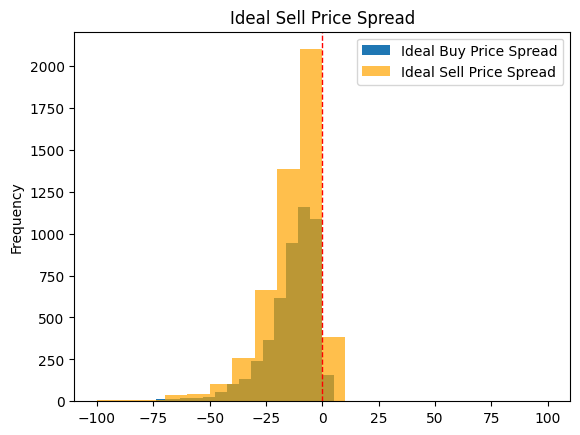

In [137]:
_ = rdf['ideal_buy_price_spread'].plot(kind='hist', title='Ideal Buy Price Spread', bins=20, range=(-100, 5))
rdf['ideal_sell_price_spread'].plot(kind='hist', title='Ideal Sell Price Spread', bins=20, range=(-100, 100), color='orange', alpha=0.7, ax=plot.gca())
plot.axvline(0, color='red', linestyle='dashed', linewidth=1)  # Add a vertical line at 0 for clarity
plot.legend(['Ideal Buy Price Spread', 'Ideal Sell Price Spread'])

#### Isolate buy and sell into 2 rows

In [138]:
#| export
def split_buy_sell(df):
    def split_side(side):
        rdf_side = df.copy()
        rdf_side['is_buy'] = True
        rdf_side['ideal_price'] = rdf_side[f'ideal_{side}_price']
        rdf_side['ideal_price_spread'] = rdf_side[f'ideal_{side}_price_spread']
        rdf_side['hedge_stop_prc'] = rdf_side[f'hedge_{side}_stop_prc']
        rdf_side.drop(columns=[f'ideal_{side}_price', f'hedge_{side}_stop_prc', f'ideal_{side}_price_spread'], inplace=True)
        return rdf_side

    rdf_buy = split_side('buy')
    rdf_sell = split_side('sell')

    rdf_combined = pd.concat([rdf_buy, rdf_sell])
    def drop_columns(df, side):
        df = df.drop(columns=[f'hedge_{side}_stop_idx', f'hedge_{side}_stop_prc'])
        df = df.drop(columns=[f'ideal_{side}_price', f'ideal_{side}_price_spread'])
        return df
    rdf_combined = drop_columns(rdf_combined, 'buy')
    rdf_combined = drop_columns(rdf_combined, 'sell')
    return rdf_combined


In [139]:
rdf_combined = split_buy_sell(rdf)
rdf_combined.columns

Index(['ts_event', 'rtype', 'publisher_id', 'instrument_id', 'action', 'side',
       'depth', 'price', 'size', 'flags', 'ts_in_delta', 'sequence',
       'bid_px_00', 'ask_px_00', 'bid_sz_00', 'ask_sz_00', 'bid_ct_00',
       'ask_ct_00', 'bid_px_01', 'ask_px_01', 'bid_sz_01', 'ask_sz_01',
       'bid_ct_01', 'ask_ct_01', 'bid_px_02', 'ask_px_02', 'bid_sz_02',
       'ask_sz_02', 'bid_ct_02', 'ask_ct_02', 'bid_px_03', 'ask_px_03',
       'bid_sz_03', 'ask_sz_03', 'bid_ct_03', 'ask_ct_03', 'bid_px_04',
       'ask_px_04', 'bid_sz_04', 'ask_sz_04', 'bid_ct_04', 'ask_ct_04',
       'bid_px_05', 'ask_px_05', 'bid_sz_05', 'ask_sz_05', 'bid_ct_05',
       'ask_ct_05', 'bid_px_06', 'ask_px_06', 'bid_sz_06', 'ask_sz_06',
       'bid_ct_06', 'ask_ct_06', 'bid_px_07', 'ask_px_07', 'bid_sz_07',
       'ask_sz_07', 'bid_ct_07', 'ask_ct_07', 'bid_px_08', 'ask_px_08',
       'bid_sz_08', 'ask_sz_08', 'bid_ct_08', 'ask_ct_08', 'bid_px_09',
       'ask_px_09', 'bid_sz_09', 'ask_sz_09', 'bid_ct_09', '

In [140]:
len(rdf.columns)

101

#### cleanup columns

In [141]:
#| export
def cleanup_columns(df):
    for i in range(1, 10):
        df.drop(columns=[f'bid_px_0{i}', f'ask_px_0{i}'], inplace=True)
    for i in range(0, 10):
        df.drop(columns=[f'bid_sz_0{i}', f'ask_sz_0{i}'], inplace=True)
        #df.drop(columns=[f'bid_ct_0{i}', f'ask_ct_0{i}'], inplace=True)

In [142]:
cleanup_columns(rdf_combined)

#### Save result

In [149]:
if is_notebook():
    os.makedirs(save_dir, exist_ok=True)
    rdf_combined.to_csv(save_dir / 'rdf_output.csv', index=False)

# Script main()

In [ ]:
#| export
if not is_notebook():
    from pathlib import Path
    import time

    def iterate(df):
        print(f"Step 2: Adjusting for time")
        start_time = initial_start_time = time.time()
        df = adjust_for_time(df)
        print(f"Step 3: Dropping NA (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        drop_na(df)
        print(f"Step 4: Adding spread (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        add_spread(df)
        print(f"Step 4.5: Adding rolling trades columns (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        add_rolling_trades_cols(df)
        assert df['rolling_30s_bid_cnt'].notna().all(), "Column 'rolling_30s_bid_cnt' contains NaN or missing values"
        print(f"Step 5: Adding imbalance columns (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        add_imbalance_columns(df)
        print(f"Step 6: Calculating stop loss indices (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        rdf = calc_stop_loss_indices(df)
        print(f"Step 7: Calculating ideal hedge (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        calculate_ideal_hedge(df, rdf)
        assert not rdf['ideal_sell_price'].isna().any(), "Column 'ideal_sell_price' contains NaN or missing values"
        print(f"Step 8: Splitting buy and sell (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        rdf_combined = split_buy_sell(rdf)
        assert 'ideal_buy_price' not in rdf_combined.columns, "rdf contains an unexpected column 'hedge_buy_price'"
        print(f"Step 9: Cleaning up columns (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        cleanup_columns(rdf_combined)
        print(f"Step 10: Saving to CSV (took {time.time() - start_time:.2f} seconds)")
        start_time = time.time()
        return rdf_combined
    
    def do_save(df, date, symbol):
        filename = f'{save_dir}/rdf_output_{date}_{symbol}.csv'
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    def do_all(date):
        
        print("Step 1: Loading data")
        df = load_data(date)

        for symbol in df.symbol.unique():
            initial_start_time = time.time()
            print(f"Step 1.1: Processing symbol: {symbol}")
            symbol_df = df[df.symbol == symbol].copy()     # copy otherwise it's complaining about working on a slice
            symbol_df.reset_index(drop=True, inplace=True)
            rdf_combined = iterate(symbol_df)
            do_save(rdf_combined, date, symbol)
            print(f"**************  (took {time.time() - initial_start_time:.2f} seconds)")
            print()

        del df
        del symbol_df
        del rdf_combined
        import gc
        gc.collect()

    import argparse
    # Parse command-line arguments
    parser = argparse.ArgumentParser(description="Process market data.")
    parser.add_argument("--date", type=str, help="Specify the date to process (format: YYYYMMDD).")
    args = parser.parse_args()

    if args.date:
        for date in args.date.split(","):
            print(f"Processing data for date: {date}")
            do_all(date)
    else:
        print("process all")
        # Define the directory and pattern
        directory = Path("../market")
        pattern = "*mbp-10*"
        # Iterate over files matching the pattern
        for file_path in directory.glob(pattern):
            if "Zone.Identifier" in file_path.name:
                continue
            print(f"Processing {file_path}")
            # Extract the date from the filename
            date_str = file_path.name[10:18]
            print(f"Extracted date: {date_str}")
            do_all(date_str)


In [155]:
#| hide
import nbdev; nbdev.nbdev_export()

# For the future

### search of one order triggering more than one execution

### search of iceberg orders

### Consider latency

### Spread could be calculated based on an average spread instead of the immediate value